# Лабораторна робота №4  
## Обробка зображень та робота з наборами файлів цифрових зображень

### Мета
Отримати знання та навики в обробці цифрових зображень за допомогою бібліотек Pillow та/або OpenCV та роботі з обробки набору зображень.

### Завдання 1. Робота з набором файлів.
1. Сформувати в папці на диску набір із 15 зображень різних форматів, розмірів та колірних моделей. Додати туди 2-3 файли, що не є зображеннями.
2. Створити функцію, що в якості аргумента приймає адресу папки на диску та повертає датафрейм з наступною інформацією про зображення, що знаходяться в папці:
   - ім’я файлу;
   - кольорову модель;
   - формат;
   - кількість каналів у зображенні;
   - розмір файлу у байтах, округлених до двох знаків після коми;
   - ширину картинки;
   - висоту картинки;
   - повний шлях до файлу;
   - зменшене зображення.

**Зауваження:**
- Якщо файл не є зображенням, не додавати інформацію про нього в датафрейм.
- Для обробки набору файлів можете скористатися вбудованими модулями [glob](https://docs.python.org/3/library/glob.html), або [zipfile](https://docs.python.org/3/library/zipfile.html).
- Для відображення картинки в датафреймі можете скористатись методом, описаним в [наступному матеріалі](https://www.kaggle.com/code/stassl/displaying-inline-images-in-pandas-dataframe/notebook).



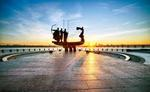
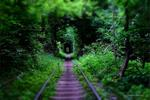
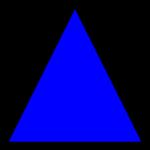
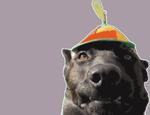
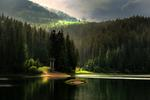
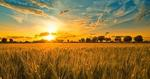
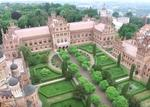
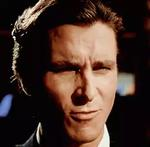
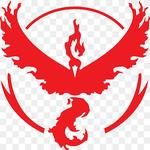
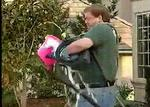
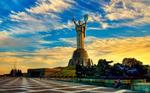
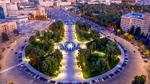
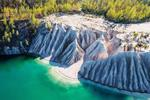
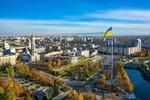
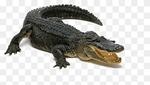

In [1]:
import os
import glob
import base64
import random
import pandas as pd
import numpy as np
from PIL import Image, ImageEnhance
from io import BytesIO
from IPython.display import HTML

pd.set_option('display.max_colwidth', None)

def get_thumbnail(path):
    i = Image.open(path)
    if i.mode in ("P", "L", "RGBA"):
        i = i.convert("RGB")
    i.thumbnail((150, 150), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def image_info(folder_path):
    image_files = glob.glob(os.path.join(folder_path, '*'))
    
    data = {
        'filename': [],
        'color_mode': [],
        'format': [],
        'num_channels': [],
        'file_size_mb': [],
        'width': [],
        'height': [],
        'full_path': [],
        'image': []
    }
    
    for file_path in image_files:
        try:
            with Image.open(file_path) as img:
                data['filename'].append(os.path.basename(file_path))
                data['color_mode'].append(img.mode)
                data['format'].append(img.format)
                data['num_channels'].append(len(img.getbands()))
                data['file_size_mb'].append(round(os.path.getsize(file_path) / (1024 * 1024), 2))
                data['width'].append(img.width)
                data['height'].append(img.height)
                data['full_path'].append(os.path.abspath(file_path))
                data['image'].append(file_path)
        except (IOError, OSError):
            continue
    
    df = pd.DataFrame(data)
    
    return HTML(df.to_html(formatters={'image': image_formatter}, escape=False))

image_info('/home/vlad_322/Documents/Lb5Images')

### Завдання 2.
Створити функцію, що в якості аргумента приймає:
   - шлях до папки;
   - назва вихідного зображення;
   - кількість зображень в рядку;
   - кількість зображень в стовпчику

і повертає зображення постера. Вважаємо, що постер є прямокутним і число картинок в постері a x b, де а – число стовпчиків, а b – число рядків.

**Зауваження:**
1) Створити функцію, що перетворює картинку на квадрат з максимально можливим розміром сторони (наприклад, якщо картинка розміром 800x533, то вихідний розмір повинен бути 533x533). Обрізаємо картинку з двох країв, тобто розмір розраховуємо від центру.
2) Всі картинки, з яких створено постер, повинні бути однакового розміру, тобто після обрізки необхідно змінити розмір, наприклад, на 500x500.
3) Картинки для додавання в постер обирати випадковим чином. Картинки можуть повторюватись.
4) На картинку «накласти фільтр» червоного, зеленого, синього, жовтого, пурпурного або голубого кольорів, що також обираються випадковим чином та можуть повторюватись.
5) Надати 3-4 варіанти постерів, що збережено у файлах на диску.
6) Використовувати зображення, що знаходяться в папці, що сформована в завданні 1
7) Для обробки зображень використовувати бібліотеки Pillow та/або OpenCV.

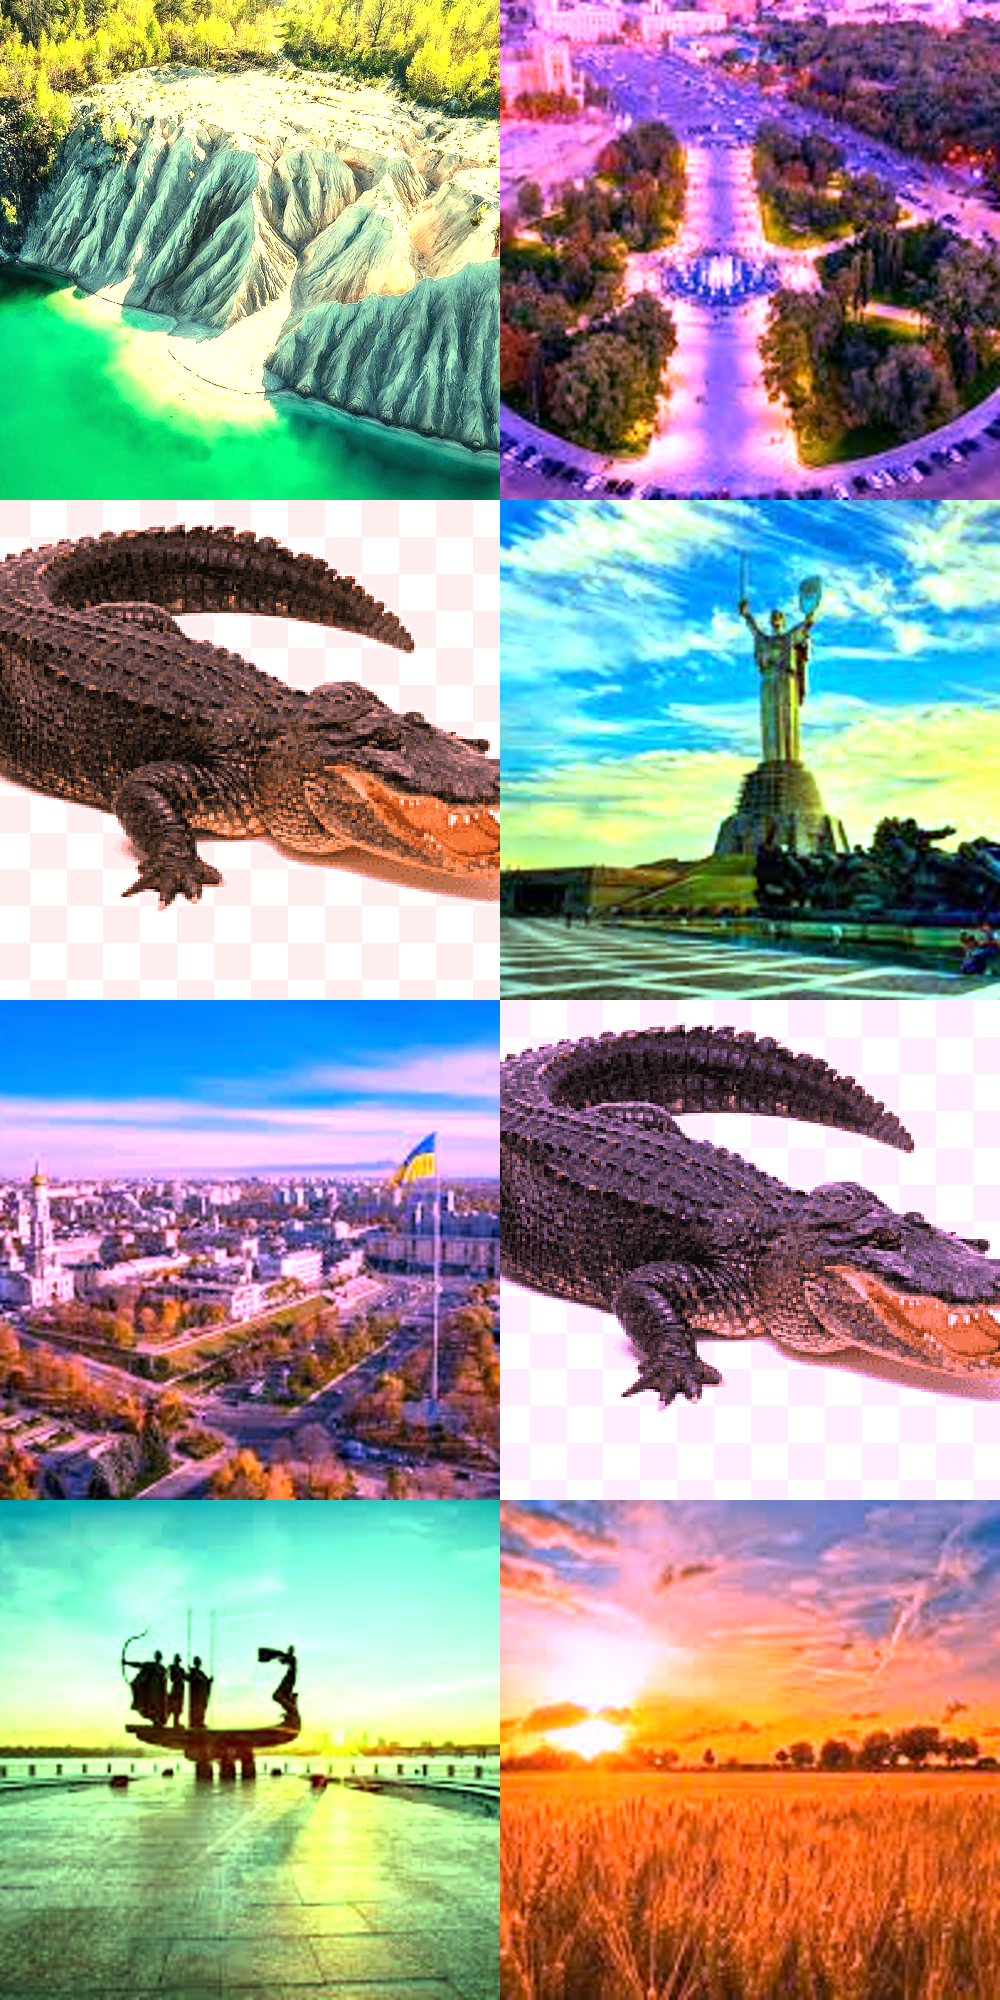

In [2]:
def square_crop(image):
    width, height = image.size
    min_side = min(width, height)
    left = (width - min_side) // 2
    top = (height - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    return image.crop((left, top, right, bottom))

def apply_color_filter(image, color_filter):
    image = image.convert("RGB")
    
    r, g, b = image.split()
    if color_filter == "red":
        r = r.point(lambda i: i * 1.5)
    elif color_filter == "green":
        g = g.point(lambda i: i * 1.5)
    elif color_filter == "blue":
        b = b.point(lambda i: i * 1.5)
    elif color_filter == "yellow":
        r = r.point(lambda i: i * 1.5)
        g = g.point(lambda i: i * 1.5)
    elif color_filter == "purple":
        r = r.point(lambda i: i * 1.5)
        b = b.point(lambda i: i * 1.5)
    elif color_filter == "cyan":
        g = g.point(lambda i: i * 1.5)
        b = b.point(lambda i: i * 1.5)
    
    return Image.merge("RGB", (r, g, b))

def create_poster(folder_path, output_name, cols, rows):
    image_files = glob.glob(os.path.join(folder_path, '*'))

    image_files = [f for f in image_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.svg'))]
    
    if len(image_files) < cols * rows:
        print("Недостатньо зображень для створення постера.")
        return

    images = []
    for _ in range(cols * rows):
        file_path = random.choice(image_files)
        try:
            img = Image.open(file_path)
            img = square_crop(img)
            img = img.resize((500, 500))
            
            color_filters = ["red", "green", "blue", "yellow", "purple", "cyan"]
            color_filter = random.choice(color_filters)
            img = apply_color_filter(img, color_filter)
            
            images.append(img)
        except (IOError, OSError):
            print(f"Пропущений файл: {file_path} - не є зображенням.")
            continue

    poster_width = cols * 500
    poster_height = rows * 500
    poster = Image.new('RGB', (poster_width, poster_height))

    for index, img in enumerate(images):
        x = (index % cols) * 500
        y = (index // cols) * 500
        poster.paste(img, (x, y))

    poster.save(f"{output_name}")

    return poster

img1 = create_poster('/home/vlad_322/Documents/Lb5Images', 'poster2x4.jpg', 2, 4)
img1

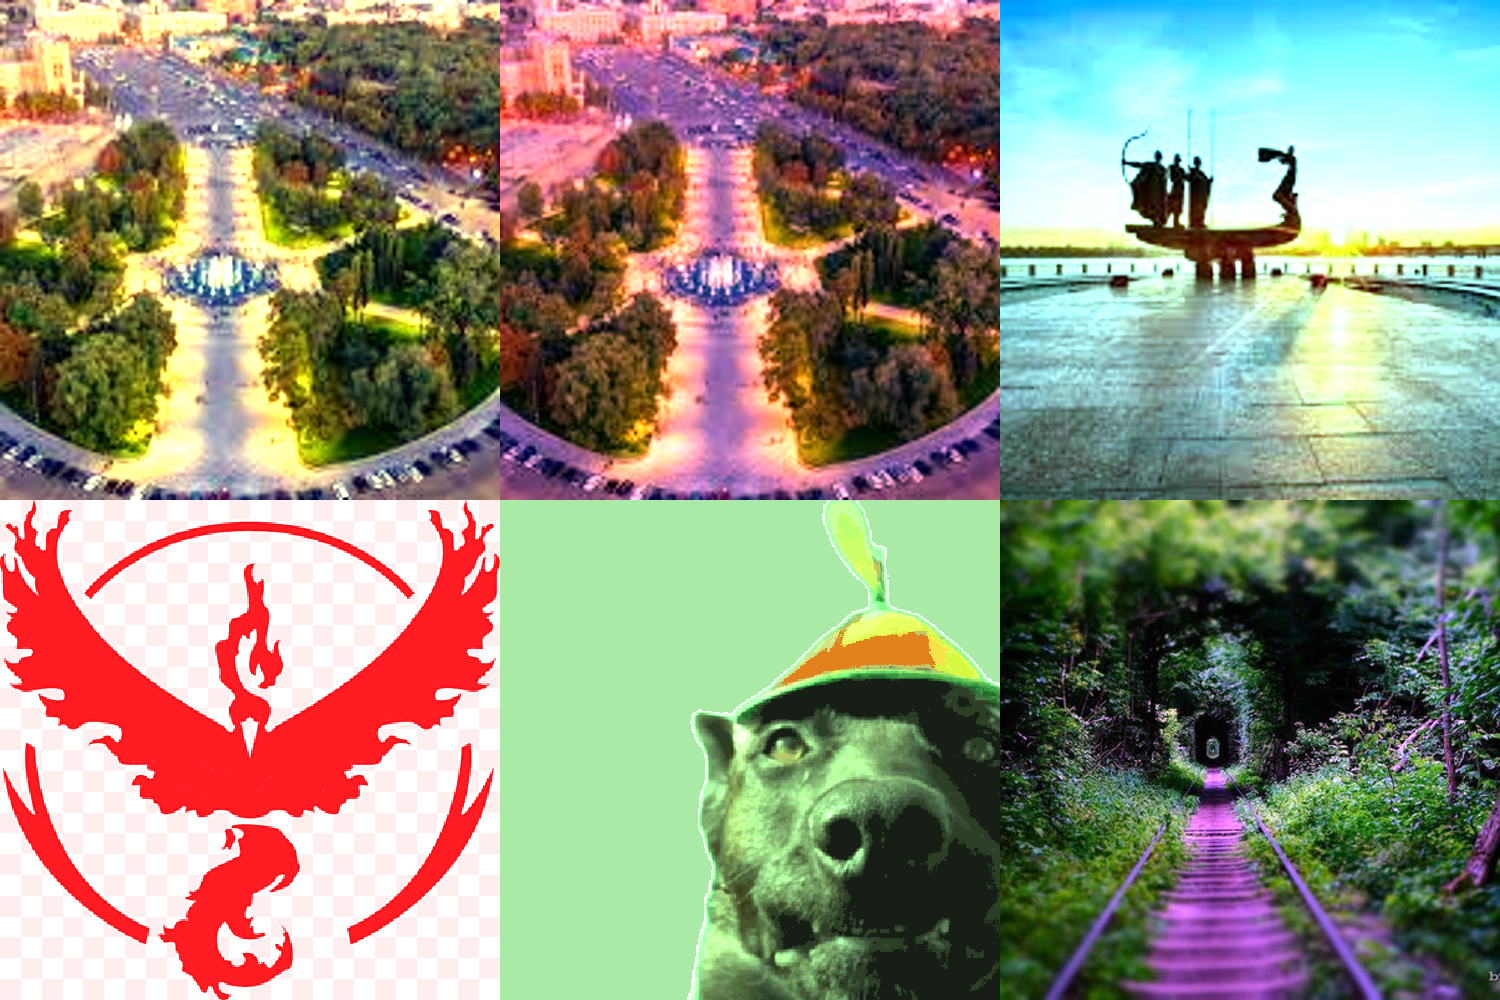

In [3]:
img2 = create_poster('/home/vlad_322/Documents/Lb5Images', 'poster3x2.png', 3, 2)
img2